In [2]:
#*
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import os
import keras
from keras import regularizers
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [3]:
#*
train_dir = './data/asl_alphabet_train'
test_dir = './data/asl_alphabet_test'

In [4]:
#*
# dict for mapping an integer for each class/label
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    images_list = []
    labels_list = []
    size = (64,64)
    
    for folder in os.listdir(train_dir):
        for imgfile in os.listdir(f'{train_dir}/{folder}'):
            curr_img = cv2.imread(f'{train_dir}/{folder}/{imgfile}')
            # resize image
            curr_img = cv2.resize(curr_img, size)
            # store into images and labels lists
            images_list.append(curr_img)
            labels_list.append(labels_dict[folder])

    # make np array
    images_arr = np.array(images_list)
    # normalize values
    images_arr = images_arr.astype('float32')/255.0
    # one hot encode labels
    labels_arr = keras.utils.to_categorical(labels_list)
    # split into training and testing data
    x_train, x_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size = 0.1)
    
    print(f'Loaded {len(x_train)} images for training')
    print(f'Training data shape: {x_train.shape}')
    print(f'Training labels shape: {y_train.shape}\n')
    print(f'Loaded {len(x_test)} images for testing')
    print(f'Testing data shape: {x_test.shape}')
    print(f'Testing labels shape: {y_test.shape}')
    
    return x_train, x_test, y_train, y_test

In [5]:
#*
x_train, x_test, y_train, y_test = load_data()

Loaded 78300 images for training
Training data shape: (78300, 64, 64, 3)
Training labels shape: (78300, 29)

Loaded 8700 images for testing
Testing data shape: (8700, 64, 64, 3)
Testing labels shape: (8700, 29)


In [27]:
#*
y_test_int = np.argmax(y_test,axis=1)
y_train_int = np.argmax(y_train,axis=1)

In [8]:
#*
nsamples, nx, ny, rgb = x_train.shape
new_x_train = x_train.reshape((nsamples, nx*ny*rgb))

testsamples, tx, ty, trgb = x_test.shape
new_x_test = x_test.reshape((testsamples, tx*ty*trgb))

In [9]:
from sklearn.neighbors import KNeighborsClassifier
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(new_x_train, y_train)
knntest = knn.predict(new_x_test)

In [10]:
from sklearn.metrics import classification_report
knntest_int = np.argmax(knntest,axis=1)
print(classification_report(y_test_int,knntest_int,digits=4))

              precision    recall  f1-score   support

           0     0.8708    0.9895    0.9264       286
           1     0.9936    0.9936    0.9936       312
           2     1.0000    0.9933    0.9966       299
           3     0.9825    0.9965    0.9894       282
           4     0.9818    0.9507    0.9660       284
           5     1.0000    0.9805    0.9901       307
           6     0.9934    0.9837    0.9885       307
           7     0.9843    0.9937    0.9890       316
           8     0.9865    0.9799    0.9832       299
           9     0.9942    0.9971    0.9956       341
          10     0.9860    0.9860    0.9860       286
          11     0.9931    0.9965    0.9948       287
          12     0.9938    0.9907    0.9922       321
          13     1.0000    0.9936    0.9968       314
          14     1.0000    0.9902    0.9951       306
          15     1.0000    0.9967    0.9984       306
          16     1.0000    0.9937    0.9968       317
          17     0.9596    

In [ ]:
display = metrics.ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15, 15))
display.plot(ax=ax)

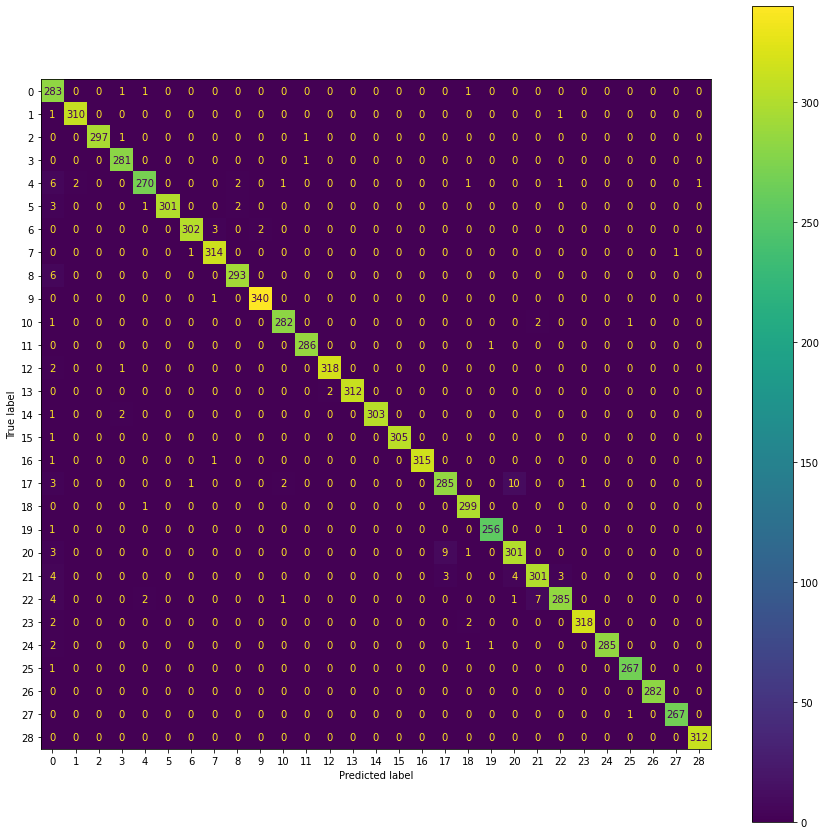

In [25]:
cm = confusion_matrix(y_test_int, knntest_int, range(0, 29))
#cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print(cm)
display = metrics.ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15, 15))
display.plot(ax=ax)

In [19]:

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
n_classes = 29

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_int[i], knntest_int[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_int.ravel(), knntest_int.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

TypeError: Singleton array 7 cannot be considered a valid collection.

In [ ]:
knnfpr, knntpr, knnthres = metrics.roc_curve(y_test_int, knntest_int, pos_label='your label')
knnauc = metrics.auc(knnfpr, knntpr)

plt.title('ROC Curve')
plt.plot(knnfpr, knntpr, 'b', label = 'AUC = %0.2f' % knnauc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
new_y_test = []
num_dict = {'0':'A','1':'B','2':'C','3':'D', '4':'E', '5':'F','6':'G','7':'H', '8':'I', '9':'J', '10':'K', '11':'L', '12':'M',
                   '13':'N','14':'O', '15':'P', '16':'Q','17':'R','18':'S','19':'T','20':'U','21':'V','22':'W','23':'X','24':'Y',
                   '25':'Z', '26':'space', '27':'del', '28':'nothing'}
for x in range(0, len(y_test) - 1):
    value = y_test[x]
    for y in range(0, len(value) - 1):
        if value[y] == 1:
            new_y_test.append(num_dict[str(y)])
    if len(new_y_test) <= x:
        new_y_test.append(False)
new_y_test.append(False)
print(len(new_y_test))
print(len(y_test))

8700
8700



Accuracy of training for 5 decision trees: 0.9960153256704981

Accuracy of testing: 0.9817241379310345

Precision of testing: 0.9870565121923033

Recall of testing: 0.9817241379310345


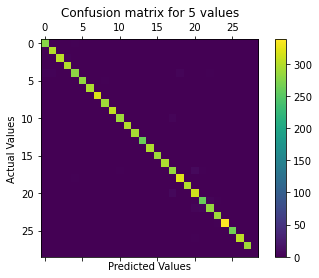


Accuracy of training for 10 decision trees: 0.9560791826309067

Accuracy of testing: 0.9405747126436782

Precision of testing: 0.9810574271670064

Recall of testing: 0.9405747126436782


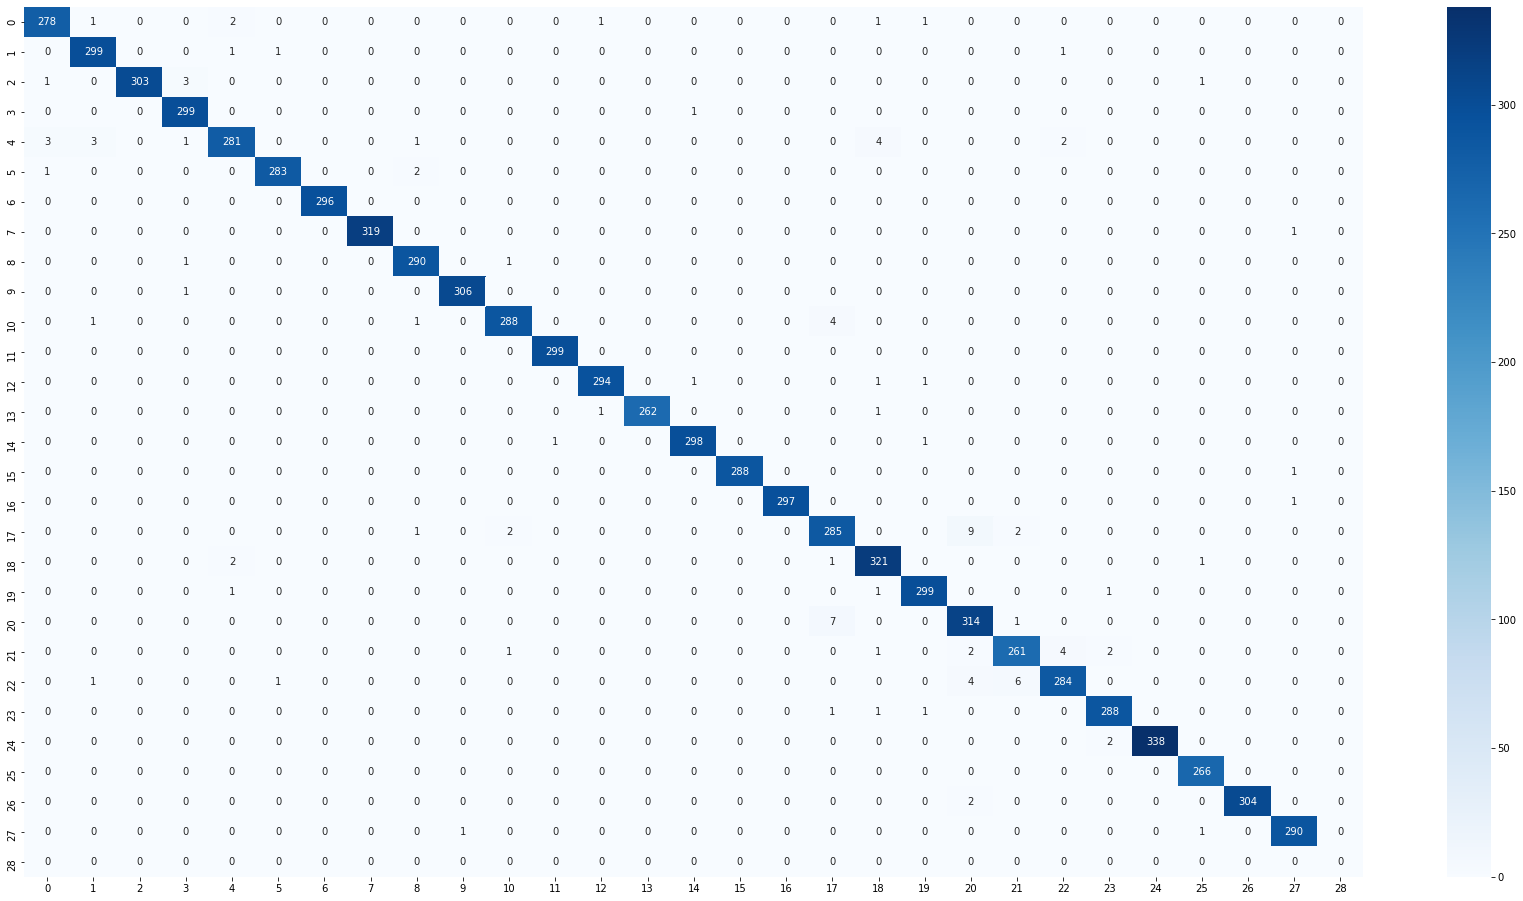

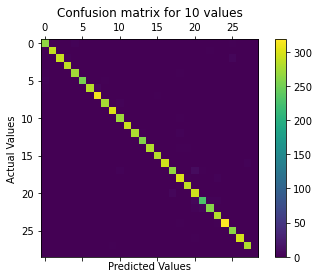

In [8]:
#k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

newknntest = []

neighbors = [5, 10, 100]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(new_x_train, y_train)
    y_trainpred = knn.predict(new_x_train)
    knntrain_int = np.argmax(y_trainpred,axis=1)
    print(classification_report(y_test_int,knntrain_int,digits=4))
    #accuracy = metrics.accuracy_score(y_train, y_trainpred)
    #print('\nAccuracy of training for {} k value: {}'.format(i, accuracy))

    knntest = knn.predict(new_x_test)
    knntest_int = np.argmax(knntest,axis=1)
    print(classification_report(y_test_int,knntest_int,digits=4))


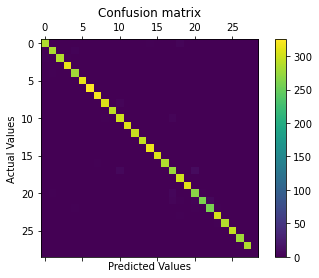

In [9]:
new_y_pred = []
for x in range(0, len(newknntest) - 1):
    value = newknntest[x]
    for y in range(0, len(value) - 1):
        if value[y] == 1:
            new_y_pred.append(num_dict[str(y)])
    if len(new_y_pred) <= x:
        new_y_pred.append(False)
new_y_pred.append(False)

cm = confusion_matrix(new_y_test, new_y_pred, labels)
#cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for {} values'.format(i))
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

plt.figure(figsize=(30, 16))
sns.heatmap(cm, annot=True, fmt='000', cmap='Blues')

In [22]:
print(len(new_y_test))

8700


<AxesSubplot:>

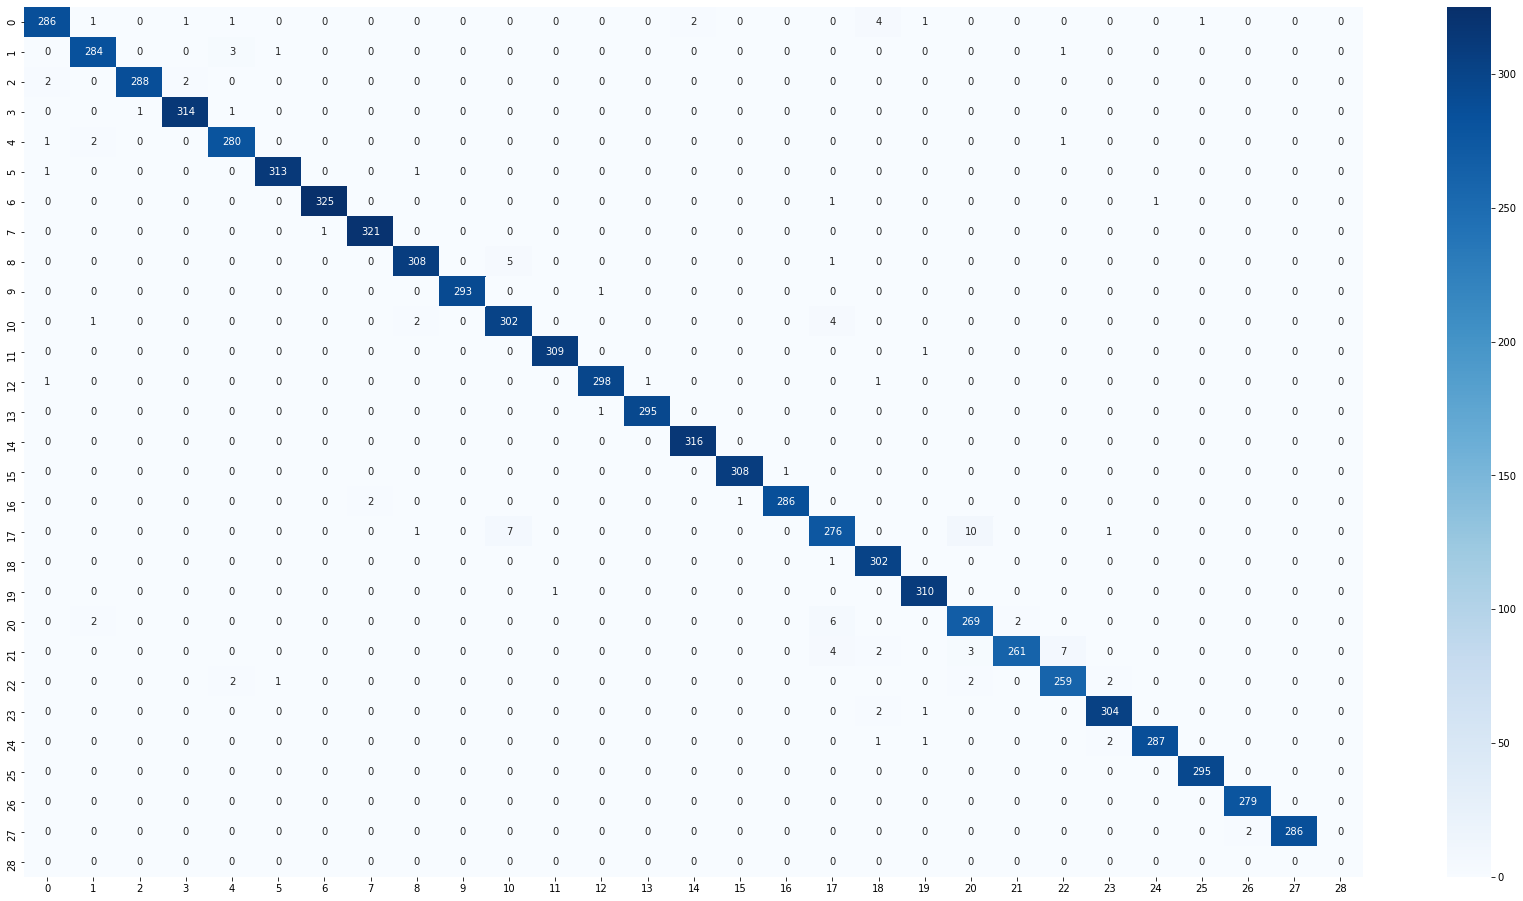

In [18]:
import seaborn as sns
plt.figure(figsize=(30, 16))
sns.heatmap(cm, annot=True, fmt='000', cmap='Blues')

In [18]:
print(new_y_test[0])

N


In [19]:
print(new_y_pred[0])

N


In [17]:
print(metrics.accuracy_score(new_y_test, new_y_pred))

0.9816091954022989


In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(new_x_train, y_train)
y_trainpred = knn.predict(new_x_train)
accuracy = metrics.accuracy_score(y_train, y_trainpred)
print('\nAccuracy of training : {}'.format(accuracy))

KeyboardInterrupt: 

In [60]:
#trainknn = KNeighborsClassifier(n_neighbors=282)
#trainknn = trainknn.fit(new_x_train, y_train)
#y_trainpred = trainknn.predict(new_x_train)
#accuracy = metrics.accuracy_score(y_train, ytrain)
#print('\nAccuracy of training: {}'.format(i, accuracy))
knn = KNeighborsClassifier(n_neighbors=282)
knn = knn.fit(new_x_train, y_train)

knntest = knn.predict(new_x_test)
testaccuracy = metrics.accuracy_score(y_test, knntest)
print('\nAccuracy of testing: {}'.format(testaccuracy))
precision = metrics.precision_score(y_test, knntest, average='micro')
print('\nPrecision of testing: {}'.format(precision))
recall = metrics.recall_score(y_test, knntest, average='micro')
print('\nRecall of testing: {}'.format(recall))


Accuracy of testing: 0.16954022988505746

Precision of testing: 0.7829087048832272

Recall of testing: 0.16954022988505746


In [34]:
#*
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

trees = [5, 10, 20]
for i in trees:
    rf = RandomForestClassifier(n_estimators=i)
    rf = rf.fit(new_x_train, y_train)
    rftrain = rf.predict(new_x_train)
    #accuracy = metrics.accuracy_score(y_train, rftrain)
    #print('\nAccuracy of training for {} decision trees: {}'.format(i, accuracy))

    rftrain_int = np.argmax(rftrain,axis=1)
    print(classification_report(y_test_int,rftrain_int,digits=4))
    #accuracy = metrics.accuracy_score(y_train, y_trainpred)
    #print('\nAccuracy of training for {} k value: {}'.format(i, accuracy))
    
    rftest = rf.predict(new_x_test)
    rftest_int = np.argmax(rftest,axis=1)
    print(classification_report(y_test_int,rftest_int,digits=4))


Accuracy of testing: 0.8975862068965518

Precision of testing: 0.9969360398314822

Recall of testing: 0.8975862068965518

Accuracy of testing: 0.9331034482758621

Precision of testing: 0.9990155057839035

Recall of testing: 0.9331034482758621

Accuracy of testing: 0.9362068965517242

Precision of testing: 0.9988962472406181

Recall of testing: 0.9362068965517242


<AxesSubplot:>

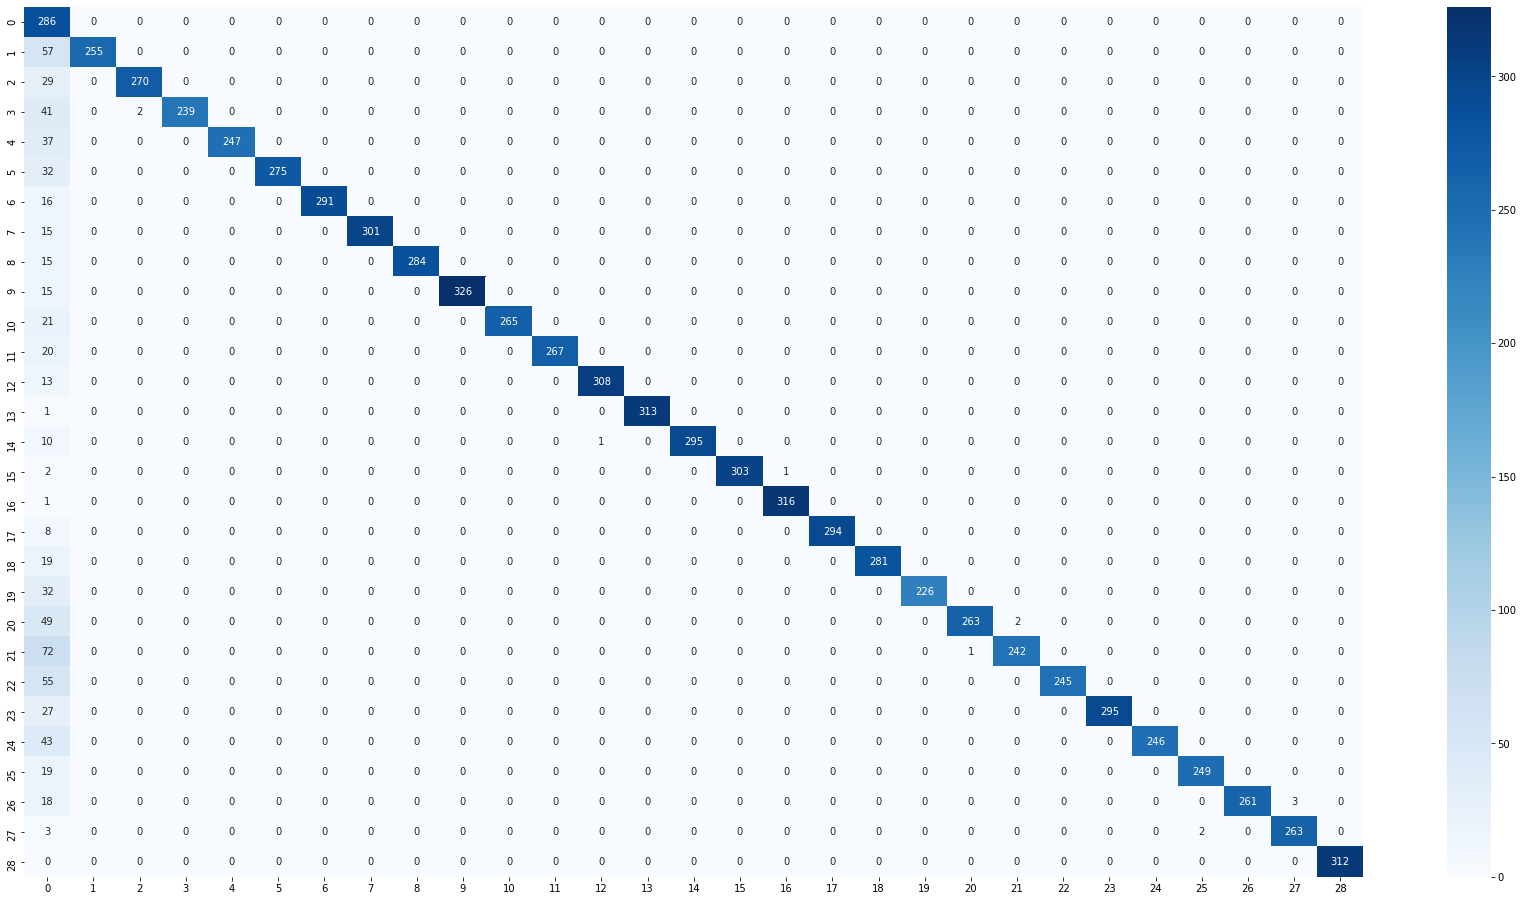

In [21]:
#*
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)
rf = rf.fit(new_x_train, y_train)
rftrain = rf.predict(new_x_train)
rftest = rf.predict(new_x_test)
rftest_int = np.argmax(rftest,axis=1)
cm = confusion_matrix(y_test_int, rftest_int, range(0, 29))
#cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print(cm)

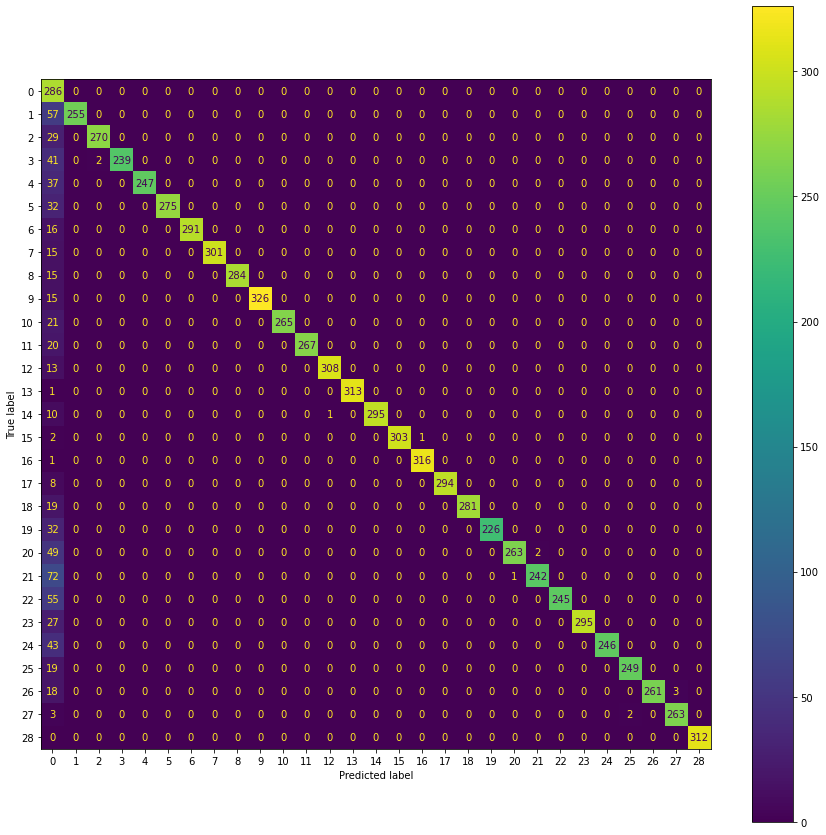

In [24]:
display = metrics.ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15, 15))
display.plot(ax=ax)

In [29]:
rftrain_int = np.argmax(rftrain,axis=1)
print(classification_report(y_train_int, rftrain_int, digits=4))

              precision    recall  f1-score   support

           0     0.9808    1.0000    0.9903      2714
           1     1.0000    0.9981    0.9991      2688
           2     1.0000    0.9993    0.9996      2701
           3     1.0000    0.9985    0.9993      2718
           4     1.0000    0.9974    0.9987      2716
           5     1.0000    0.9985    0.9993      2693
           6     1.0000    0.9993    0.9996      2693
           7     1.0000    0.9996    0.9998      2684
           8     1.0000    0.9996    0.9998      2701
           9     1.0000    0.9996    0.9998      2659
          10     1.0000    0.9996    0.9998      2714
          11     1.0000    0.9996    0.9998      2713
          12     1.0000    0.9996    0.9998      2679
          13     1.0000    0.9996    0.9998      2686
          14     1.0000    1.0000    1.0000      2694
          15     1.0000    1.0000    1.0000      2694
          16     1.0000    1.0000    1.0000      2683
          17     1.0000    

In [30]:
rftrain_int.shape

(78300,)

In [22]:
print(classification_report(y_test_int,rftest_int,digits=4))

              precision    recall  f1-score   support

           0     0.2992    1.0000    0.4605       286
           1     1.0000    0.8173    0.8995       312
           2     0.9926    0.9030    0.9457       299
           3     1.0000    0.8475    0.9175       282
           4     1.0000    0.8697    0.9303       284
           5     1.0000    0.8958    0.9450       307
           6     1.0000    0.9479    0.9732       307
           7     1.0000    0.9525    0.9757       316
           8     1.0000    0.9498    0.9743       299
           9     1.0000    0.9560    0.9775       341
          10     1.0000    0.9266    0.9619       286
          11     1.0000    0.9303    0.9639       287
          12     0.9968    0.9595    0.9778       321
          13     1.0000    0.9968    0.9984       314
          14     1.0000    0.9641    0.9817       306
          15     1.0000    0.9902    0.9951       306
          16     0.9968    0.9968    0.9968       317
          17     1.0000    

In [ ]:
rffpr, rftpr, rfthres = metrics.roc_curve(y_test_int, rftest_int)
rfauc = metrics.auc(rffpr, rftpr)

plt.title('ROC Curve')
plt.plot(rffpr, rftpr, 'b', label = 'AUC = %0.2f' % rfauc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
new_y_train = []
num_dict = {'0':'A','1':'B','2':'C','3':'D', '4':'E', '5':'F','6':'G','7':'H', '8':'I', '9':'J', '10':'K', '11':'L', '12':'M',
                   '13':'N','14':'O', '15':'P', '16':'Q','17':'R','18':'S','19':'T','20':'U','21':'V','22':'W','23':'X','24':'Y',
                   '25':'Z', '26':'space', '27':'del', '28':'nothing'}
for x in range(0, len(y_train) - 1):
    value = y_train[x]
    for y in range(0, len(value) - 1):
        if value[y] == 1:
            new_y_train.append(num_dict[str(y)])
    if len(new_y_train) <= x:
        new_y_train.append(False)
new_y_train.append(False)
print(len(new_y_train))
print(len(y_train))

78300
78300


In [ ]:
# Decision Tree with AdaBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

model = DecisionTreeClassifier()
model = model.fit(new_x_train, y_train)

In [33]:
#*
# Decision Tree with AdaBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

base = [5, 10, 20]
for i in base:
    model = DecisionTreeClassifier()
    abc = AdaBoostClassifier(n_estimators=i, base_estimator=model) 
    abc = abc.fit(new_x_train, y_train_int)
    #abctrain = abc.predict(new_x_train)

    #accuracy = metrics.accuracy_score(y_train, abctrain)
    #print('\nAccuracy of training for base classifier {}: {}'.format(i, accuracy))
    
    #abctrain_int = np.argmax(abctrain,axis=1)
    #print(classification_report(y_test_int,abctrain_int,digits=4))
    
    #accuracy = metrics.accuracy_score(y_train, y_trainpred)
    #print('\nAccuracy of training for {} k value: {}'.format(i, accuracy))

    abctest = abc.predict(new_x_test)
    print(classification_report(y_test_int,abctest,digits=4))
    #testaccuracy = metrics.accuracy_score(y_test, abctest)
    #print('\nAccuracy of testing or base classifier {}: {}'.format(i, testaccuracy))
    #precision = metrics.precision_score(y_test, abctest, average='micro')
    #print('\nPrecision of testing for base classifier {}: {}'.format(i, precision))
    #recall = metrics.recall_score(y_test, abctest, average='micro')
    #print('\nRecall of testing for base classifier {}: {}'.format(i, recall))

In [ ]:
#*
cm = confusion_matrix(y_test_int, abctest, range(0, 29))
display = metrics.ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15, 15))
display.plot(ax=ax)

In [ ]:
abcfpr, abctpr, abcthres = metrics.roc_curve(y_test_int, abctest_int)
abcauc = metrics.auc(abcfpr, abctpr)

plt.title('ROC Curve')
plt.plot(abcfpr, abctpr, 'b', label = 'AUC = %0.2f' % abcauc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
print(y_pred.shape)

(8700, 29)


In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
labels = ['A','B','C','D', 'E', 'F','G','H', 'I', 'J', 'K', 'L', 'M',
                   'N','O', 'P', 'Q','R','S','T','U','V','W','X','Y',
                   'Z', 'space', 'del', 'nothing']
#cm = confusion_matrix(y_test, y_pred, labels)
new_y_test = []
for x in y_test:
    for y in range(0, len(x) - 1):
        if x[y] == 1:
            new_y_test.append(num_dict[str(y)])
new_y_pred = []
for x in y_pred:
    for y in range(0, len(x) - 1):
        if x[y] == 1:
            new_y_pred.append(num_dict[str(y)])
cm = confusion_matrix(new_y_test, new_y_pred, labels)
#cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [8375, 8331]